In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
import PIL
from PIL import Image
import cv2

In [3]:
#Use this if you are running on any Cuda enabled system
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# Define hyperparameters
# batch_size = 128
# z_dim = 100
# N = 500
# X_dim = 3*32*32

input_dim = 32*32
batch_size = 128
n_epochs = 100

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor()])

CIFAR10_train = datasets.CIFAR10('./data', 
               transform=transform, 
               download=True, train=True)

loader_train = DataLoader(CIFAR10_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)

CIFAR10_test = datasets.CIFAR10('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True, train=False)

loader_test = DataLoader(CIFAR10_test, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2) 

100%|██████████| 170498071/170498071 [00:07<00:00, 21452163.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [41]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder= nn.Sequential(
            nn.Conv2d(3,16,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,32,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16,3,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid(),
        )

    def forward(self,x):
      encoded= self.encoder(x)
      decoded=self.decoder(encoded)

      return decoded

In [51]:
from torchsummary import summary
ae = AE().to(device)
summary(ae,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             784
       BatchNorm2d-2           [-1, 16, 16, 16]              32
              ReLU-3           [-1, 16, 16, 16]               0
            Conv2d-4             [-1, 32, 8, 8]           8,224
       BatchNorm2d-5             [-1, 32, 8, 8]              64
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 4, 4]          32,832
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
  ConvTranspose2d-10             [-1, 32, 8, 8]          32,800
      BatchNorm2d-11             [-1, 32, 8, 8]              64
             ReLU-12             [-1, 32, 8, 8]               0
  ConvTranspose2d-13           [-1, 16, 16, 16]           8,208
      BatchNorm2d-14           [-1, 16,

In [52]:
def mask_function(image):
  height,width,channels= image.shape
  num_patches = int((height * width * 0.5) / 4)
  mask = np.zeros((height, width), dtype=np.uint8)
  for i in range(num_patches):
      x = np.random.randint(0, width - 2)
      y = np.random.randint(0, height - 2)
      mask[y:y+2, x:x+2] = 1
  masked_image = image * mask[:, :, np.newaxis]
  return masked_image

In [ ]:
optimizer = torch.optim.Adam(ae.parameters(),lr=0.01)
train_loss_list=[]
test_loss_list=[]
for epoch in range(n_epochs):
  ae.train()
  train_loss = 0
  test_loss=0
  loss = nn.MSELoss()
  for batch_idx, (data, labels) in enumerate(loader_train):
    data2=torch.clone(data)
    for i in range (batch_size):
      img=np.transpose(data2[i],(1,2,0))
      img= mask_function(img)
      img=np.transpose(img,(2,0,1))
      data2[i]=img
    optimizer.zero_grad()
    x_hat= ae(data2.to(device))
    l=loss(x_hat.to(device),data.to(device))
    l.backward()
    optimizer.step()
    train_loss+=l

  train_loss = train_loss/len(loader_train)
  train_loss_list.append(train_loss.item())
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
  for batch_idx, (data, labels) in enumerate(loader_test):
    data2=torch.clone(data)
    for i in range (batch_size):
      img=np.transpose(data2[i],(1,2,0))
      img= mask_function(img)
      img=np.transpose(img,(2,0,1))
      data2[i]=img
    x_hat= ae(data2.to(device))
    l=loss(x_hat.to(device),data.to(device))
    test_loss+=l
  if epoch%10==0:
    test_loss=test_loss/len(loader_test)
    test_loss_list.append(test_loss.item())

Epoch: 0 	Training Loss: 0.016820
Epoch: 1 	Training Loss: 0.009609
Epoch: 2 	Training Loss: 0.008647
Epoch: 3 	Training Loss: 0.008231
Epoch: 4 	Training Loss: 0.008015


In [45]:
image,label= CIFAR10_train[0]
img=np.transpose(image,(1,2,0))
img= mask_function(img)
img=np.transpose(img,(2,0,1))
img=torch.tensor(img,dtype=torch.float).unsqueeze(0)
x_hat= ae(img.to(device))
x_hat=x_hat.to('cpu').detach().numpy().squeeze(0)
img=img.to('cpu').detach().numpy().squeeze(0)

<ipython-input-45-154c50455c02>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img=torch.tensor(img,dtype=torch.float).unsqueeze(0)


Text(0.5, 1.0, 'Predicted Image')

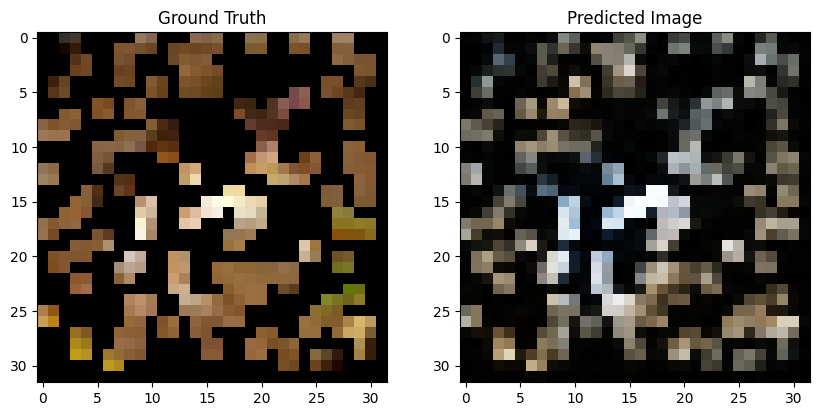

In [46]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(2,2,1)
plt.imshow(np.transpose(img,(1,2,0)))
plt.title('Ground Truth')
fig.add_subplot(2,2,2)
plt.imshow(np.transpose(x_hat,(1,2,0)))
plt.title('Predicted Image')

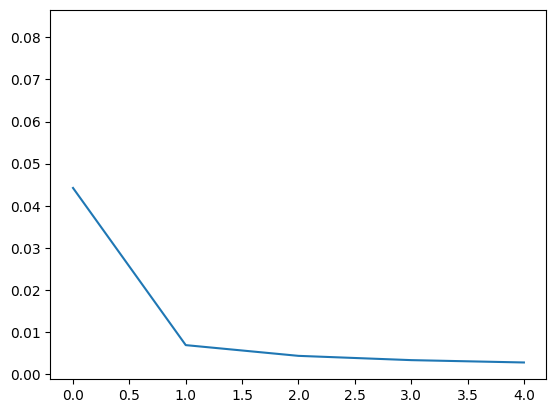

In [47]:
plt.plot(train_loss_list)
plt.plot(test_loss_list)